In [ ]:
# Multi-output neural network
# Microbiome deconstruction 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import hctmicrobiomemskcc.dataloading.dataloading as hct_data
import hctmicrobiomemskcc.tools.microbiotatools as hct_tools

# data generated from rotational_project1.jpynb
df1 = pd.read_csv('/Users/brian/Documents/2021Spring/Jonas_Rotation/hctmicrobiome/notebooks/deconstruction_exploration/df_deconstruction_ASV.csv')
df1 = df1.iloc[:,1:] # remove first column for redundancy 

/Users/brian/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Prevalence Filter
non_zero_ASV_patients = df1.groupby('PatientID').sum().astype(bool).sum(axis=0)
prevalence = 0.8
total_patients = len(df1.groupby('PatientID').sum())
prev_filter = non_zero_ASV_patients/total_patients > prevalence
ASVs_keep = prev_filter.index[prev_filter.values]


In [4]:
temp1 = df1[["SampleID","PatientID","Consistency"]]
temp2 = df1[ASVs_keep]
df1 = pd.concat([temp1, temp2], axis=1)

In [5]:
# I want to use the first 2 days in the deconstruction pattern to predict the 3rd. 
# subset 3rd row out
df_y = df1[df1.index % 3 == 0]  # Selects every 3rd raw starting from 0
df_y = df_y.drop(['SampleID', 'Consistency', 'Day'], axis = 1) # S3 ASV values 

df_temp = df1[df1.index % 3 != 0]  # excludes every 3rd row
df_temp = df_temp.drop(['SampleID', 'Consistency', 'Day'], axis = 1)
df_temp_S1 = df_temp[df_temp.index % 2 == 0]
df_temp_S2 = df_temp[df_temp.index % 2 != 0]
df_x = pd.merge(df_temp_S1, df_temp_S2, on  = 'PatientID')


a = df_x['PatientID'].unique() 
b = df_y['PatientID'].unique()
keeps = set(a) & set(b)

# keeping only patients in both df_x and df_y
df_y = df_y[df_y['PatientID'].isin(keeps)]
df_x = df_x[df_x['PatientID'].isin(keeps)]



In [6]:
df_y.shape

(487, 10)

In [7]:
Y_temp = df_y.drop("PatientID", axis = 1).to_numpy()
X_temp = df_x.drop("PatientID", axis = 1).to_numpy()


In [8]:
# min max scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_temp = min_max_scaler.fit_transform(pd.DataFrame(X_temp)[:])


In [48]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest=train_test_split(X_temp, Y_temp, test_size=0.2)

In [49]:
xtrain.shape

(389, 18)

In [50]:
xtest.shape

(98, 18)

In [51]:
ytest.shape

(98, 9)

In [52]:
# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

In [53]:
# get the dataset
from keras import backend as K
import random

random.seed(10)
# get the model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(5, input_dim=n_inputs, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='random_normal', activation = 'relu'))
    model.compile(optimizer='adam', loss = 'mae', metrics=['mean_absolute_error'])
    return model
 

In [54]:

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        #print('>%.3f' % mae)
        results.append(mae)
    return results
 
# evaluate model
results = evaluate_model(xtrain, ytrain)
# summarize performance
print('mae: %.8f (%.8f)' % (mean(results), std(results)))




mae: 0.02205568 (0.00289976)


In [55]:
n_inputs, n_outputs = xtrain.shape[1], ytrain.shape[1]
model = get_model(n_inputs, n_outputs)

In [56]:
xtrain.shape

(389, 18)

In [57]:
n_inputs

18

In [58]:
ytrain.shape

(389, 9)

In [59]:
model.summary()

Model: "sequential_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_306 (Dense)            (None, 5)                 95        
_________________________________________________________________
dense_307 (Dense)            (None, 9)                 54        
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(xtrain, ytrain,validation_data = (xtest,ytest), epochs=1000, batch_size=64)


Epoch 1/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0260 - mean_absolute_error: 0.0260 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 2/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0245 - mean_absolute_error: 0.0245 - val_loss: 0.0238 - val_mean_absolute_error: 0.0238
Epoch 3/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0231 - val_mean_absolute_error: 0.0231
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0230 - mean_absolute_error: 0.0230 - val_loss: 0.0227 - val_mean_absolute_error: 0.0227
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0224 - val_mean_absolute_error: 0.0224
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 7/1000
7/7 [=========

7/7 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 102/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 103/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 104/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 105/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 106/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 107/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 152/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 153/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 154/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 155/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 156/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 157/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 202/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 203/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 204/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 205/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 206/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 207/1000
7/7 [===========

7/7 [==============================] - 0s 7ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 252/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 253/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 254/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 255/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 256/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 257/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 302/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 303/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 304/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 305/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0206 - mean_absolute_error: 0.0206 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 306/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 307/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 352/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 353/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 354/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 355/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 356/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 357/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 402/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0205 - mean_absolute_error: 0.0205 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 403/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 404/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 405/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 406/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 407/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 452/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 453/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 454/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 455/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 456/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 457/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 502/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 503/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 504/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 505/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 506/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 507/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 552/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 553/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 554/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 555/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 556/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 557/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0203 - mean_absolute_error: 0.0203 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 602/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 603/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 604/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 605/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 606/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 607/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 652/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 653/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 654/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 655/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 656/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 657/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 702/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 703/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 704/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0202 - mean_absolute_error: 0.0202 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 705/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 706/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 707/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 752/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 753/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 754/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 755/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 756/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 757/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 802/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 803/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 804/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 805/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 806/1000
7/7 [==============================] - 0s 3ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 807/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 852/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 853/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 854/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 855/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 856/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 857/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0201 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 902/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0214 - val_mean_absolute_error: 0.0214
Epoch 903/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 904/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 905/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 906/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0200 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 907/1000
7/7 [===========

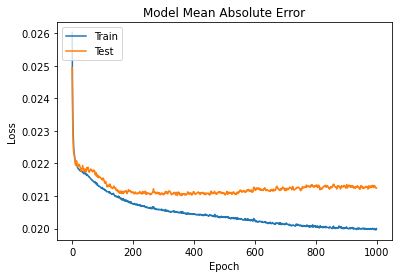

In [62]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [67]:
# second model with linear activation
def get_model2(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(5, input_dim=n_inputs, kernel_initializer='he_normal', activation='linear'))
    model.add(Dense(n_outputs, kernel_initializer='random_normal', activation = 'relu'))
    model.compile(optimizer='adam', loss = 'mae', metrics=['mean_absolute_error'])
    return model
 

In [68]:
model2 = get_model2(n_inputs, n_outputs)
history2 = model2.fit(xtrain, ytrain,validation_data = (xtest,ytest), epochs=1000, batch_size=64)



Epoch 1/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0265 - mean_absolute_error: 0.0265 - val_loss: 0.0256 - val_mean_absolute_error: 0.0256
Epoch 2/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0251 - mean_absolute_error: 0.0251 - val_loss: 0.0245 - val_mean_absolute_error: 0.0245
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0242 - mean_absolute_error: 0.0242 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237
Epoch 4/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 5/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0232 - mean_absolute_error: 0.0232 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 6/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225
Epoch 7/1000
7/7 [=========

7/7 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_absolute_error: 0.0213 - val_loss: 0.0213 - val_mean_absolute_error: 0.0213
Epoch 102/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_absolute_error: 0.0213 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 103/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_absolute_error: 0.0213 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 104/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_absolute_error: 0.0213 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 105/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 106/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 107/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 152/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 153/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 154/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 155/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 156/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 157/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 202/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 203/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 204/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 205/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 206/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 207/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 252/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 253/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 254/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 255/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 256/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 257/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 302/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 303/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 304/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 305/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 306/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 307/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 352/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 353/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 354/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 355/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 356/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 357/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 402/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 403/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 404/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 405/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 406/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 407/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 452/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 453/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 454/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 455/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 456/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 457/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 502/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 503/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 504/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 505/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 506/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 507/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 552/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 553/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 554/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 555/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 556/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 557/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 602/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 603/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 604/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 605/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 606/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 607/1000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 652/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 653/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 654/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 655/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 656/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 657/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 702/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 703/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 704/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 705/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 706/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 707/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 752/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 753/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 754/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 755/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 756/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 757/1000
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 802/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 803/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 804/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 805/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 806/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 807/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 852/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 853/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 854/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 855/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 856/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 857/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 902/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 903/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 904/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 905/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 906/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 907/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 952/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 953/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 954/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 955/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 956/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 957/1000
7/7 [===========

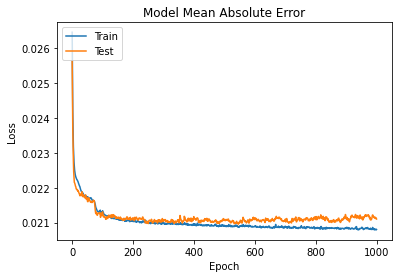

In [69]:
import matplotlib.pyplot as plt
plt.plot(history2.history['mean_absolute_error'])
plt.plot(history2.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [71]:
model2.summary()

Model: "sequential_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_316 (Dense)            (None, 5)                 95        
_________________________________________________________________
dense_317 (Dense)            (None, 9)                 54        
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1000
7/7 [==============================] - 0s 19ms/step - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0282 - val_mean_absolute_error: 0.0282
Epoch 2/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0277 - mean_absolute_error: 0.0277 - val_loss: 0.0267 - val_mean_absolute_error: 0.0267
Epoch 3/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0264 - mean_absolute_error: 0.0264 - val_loss: 0.0257 - val_mean_absolute_error: 0.0257
Epoch 4/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0254 - mean_absolute_error: 0.0254 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 5/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0246 - mean_absolute_error: 0.0246 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242
Epoch 6/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237
Epoch 7/1000
7/7 [=========

7/7 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0212 - val_mean_absolute_error: 0.0212
Epoch 102/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 103/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 104/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_absolute_error: 0.0212 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 105/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 106/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0211 - val_mean_absolute_error: 0.0211
Epoch 107/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 152/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 153/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 154/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 155/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0211 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 156/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 157/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0210 - mean_absolute_error: 0.0210 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 202/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0210 - val_mean_absolute_error: 0.0210
Epoch 203/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 204/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 205/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 206/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 207/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 252/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 253/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 254/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 255/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 256/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 257/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 302/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 303/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 304/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 305/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 306/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 307/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 352/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 353/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 354/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 355/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 356/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 357/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 402/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 403/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 404/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 405/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0209 - mean_absolute_error: 0.0209 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 406/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 407/1000
7/7 [===========

7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 452/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 453/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 454/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 455/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 456/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0209 - val_mean_absolute_error: 0.0209
Epoch 457/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 502/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 503/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 504/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 505/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 506/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 507/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 552/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 553/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 554/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 555/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 556/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 557/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 602/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 603/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 604/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 605/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 606/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 607/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 652/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 653/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 654/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 655/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 656/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 657/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 702/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 703/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 704/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 705/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 706/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 707/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 752/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 753/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 754/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 755/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 756/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 757/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 802/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 803/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0206 - val_mean_absolute_error: 0.0206
Epoch 804/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 805/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 806/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 807/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 852/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0208 - val_mean_absolute_error: 0.0208
Epoch 853/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 854/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 855/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 856/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 857/1000
7/7 [===========

7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 902/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 903/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 904/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 905/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0207 - mean_absolute_error: 0.0207 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 906/1000
7/7 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.0208 - val_loss: 0.0207 - val_mean_absolute_error: 0.0207
Epoch 907/1000
7/7 [===========

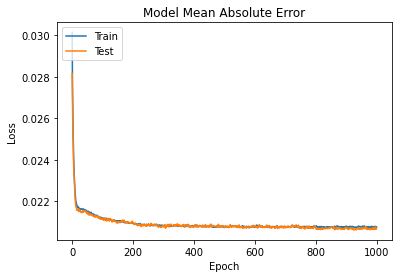

In [70]:
def get_model3(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(5, input_dim=n_inputs, kernel_initializer='he_normal', activation='linear'))
    model.add(Dense(n_outputs, kernel_initializer='random_normal', activation = 'linear'))
    model.compile(optimizer='adam', loss = 'mae', metrics=['mean_absolute_error'])
    return model
model3 = get_model3(n_inputs, n_outputs)
history3 = model3.fit(xtrain, ytrain,validation_data = (xtest,ytest), epochs=1000, batch_size=64)

import matplotlib.pyplot as plt
plt.plot(history3.history['mean_absolute_error'])
plt.plot(history3.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()